In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import gaussian_kde
import numpy as np

# Testing function for ANOVA with tukey and bonferroni post hocs

In [ ]:
def run_anova_tests(df, kpis):
    """
    Function to run ANOVA and post hoc tests (Tukey HSD and Bonferroni correction)
    on the given dataframe for a list of KPIs.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data, including 'Team' and the specified KPIs.
    kpis : list
        List of KPI column names to test.
    """
    for kpi in kpis:
        print(f"\nRunning ANOVA for {kpi}:")

        # Perform ANOVA
        model = ols(f'Q("{kpi}") ~ C(Team)', data=df).fit()
        anova_table = anova_lm(model, typ=2)

        # Display ANOVA results as a table
        print("\nANOVA Table:")
        print(tabulate(anova_table, headers='keys', tablefmt='pretty'))

        # Perform post-hoc Tukey HSD test
        tukey = pairwise_tukeyhsd(endog=df[kpi], groups=df['Team'], alpha=0.05)
        tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

        # Display Tukey HSD test as a table
        print("\nTukey HSD Test:")
        print(tabulate(tukey_df, headers='keys', tablefmt='pretty'))

        # Bonferroni correction for multiple comparisons
        p_values = tukey.pvalues
        reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

        # Get the pair comparisons from Tukey's HSD results (from tukey.summary())
        comparisons = tukey_df['group1'] + " vs " + tukey_df['group2']

        # Display Bonferroni-corrected p-values as a table
        bonferroni_df = pd.DataFrame({
            'Comparison': comparisons,
            'Original p-value': p_values,
            'Bonferroni-corrected p-value': pvals_corrected,
            'Reject Null Hypothesis': reject
        })

        print("\nBonferroni-corrected p-values:")
        print(tabulate(bonferroni_df, headers='keys', tablefmt='pretty'))

        # Check for significant comparisons after Bonferroni correction
        if not reject.any():
            print("No significant comparisons found.")
        else:
            print("\nSignificant comparisons (after Bonferroni correction):")
            significant_comparisons = bonferroni_df[bonferroni_df['Reject Null Hypothesis'] == True]
            print(tabulate(significant_comparisons, headers='keys', tablefmt='pretty'))


# Visualization Function for Teams v League Values

In [ ]:
def create_stat_visualization(df,stats,team):
    """
    Function to run visualization of statistics with a vertical line to show a specific team's value.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data, including 'Team' and the specified KPIs.
    stats : list of kpi statistics to graph
    team: string representing the desired team name to highlight
    """
    fig, axes = plt.subplots(nrows=2, ncols=int(round(max(len(stats)/2,1),0)), figsize=(15, 10))
    axes = axes.flatten()  # To easily iterate over the axes

    for idx, stat in enumerate(stats):
        # Plot the histogram
        axes[idx].hist(df[stat], alpha=0.7, label='League Distribution')  # Add label for the histogram

        # Get the value for the Boston Red Sox
        desired_team_value = df[df["Team"] == team][stat].values[0]

        # Add a vertical red line at the Red Sox value with label
        axes[idx].axvline(desired_team_value, color='red', linestyle='--', linewidth=2, label= team)

        # Set the title for each subplot
        axes[idx].set_title(stat)

        # Add the legend
        axes[idx].legend()

    plt.tight_layout()
    plt.show()



# Z Score Calculator Function

In [ ]:
def calculate_team_z_scores(df, stats, team):
    """
    Function to calculate the Z-scores for the specified team's KPIs and return them as a DataFrame.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data, including 'Team' and the specified KPIs.
    stats : list of str
        List of KPI statistics for which Z-scores will be calculated.
    team : str
        Name of the team for which Z-scores are calculated.

    Returns:
    z_scores_df : pandas.DataFrame
        DataFrame containing Team name, KPI names, and their corresponding Z-scores for the specified team.
    """
    z_scores = {}

    for stat in stats:
        mean_stat = df[stat].mean()
        std_stat = df[stat].std()
        team_value = df[df["Team"] == team][stat].values[0]
        z_score = (team_value - mean_stat) / std_stat
        z_scores[stat] = z_score

    # Create a DataFrame from the dictionary
    z_scores_df = pd.DataFrame(list(z_scores.items()), columns=['KPI', 'Z-Score'])
    z_scores_df['Team'] = team  # Add team column
    return z_scores_df


# ANOVA Testing of Batter KPIs by World Series Team

In [ ]:
# Load Excel data
df = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/Baseball.xlsx",sheet_name="Hitters")

# KPIs to test
kpis = ["G", "PA", "bWAR", "oWAR", "dWAR", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB", "Salary"]

In [ ]:
run_anova_tests(df=df, kpis=["G", "PA", "bWAR", "oWAR", "dWAR", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB", "Salary"])


Running ANOVA for G:

ANOVA Table:
+----------+--------------------+------+-------------------+-------------------+
|          |       sum_sq       |  df  |         F         |      PR(>F)       |
+----------+--------------------+------+-------------------+-------------------+
| C(Team)  | 2754.8393141945808 | 4.0  | 0.689593420351091 | 0.602463516505217 |
| Residual | 51933.371212121216 | 52.0 |        nan        |        nan        |
+----------+--------------------+------+-------------------+-------------------+

Tukey HSD Test:
+---+---------+---------+----------+--------+----------+---------+--------+
|   | group1  | group2  | meandiff | p-adj  |  lower   |  upper  | reject |
+---+---------+---------+----------+--------+----------+---------+--------+
| 0 | 2018BOS | 2019WAS |  3.3182  | 0.9991 | -33.9586 | 40.595  | False  |
| 1 | 2018BOS | 2021ATL | -14.6818 | 0.799  | -51.9586 | 22.595  | False  |
| 2 | 2018BOS | 2022HOU |  0.7727  |  1.0   | -36.5041 | 38.0495 | False  |
| 3 |

In [ ]:
# ANOVA is showing no difference for any of the KPIs measured among the teams analyzed, indicating that the teams that win the world series do not
# have statistically different KPIs for hitters at the 95% confidence level

# World Series Batting KPI Visualizations

In [ ]:
for i in kpis:
  avg = df.groupby('Team')[i].mean()
  df[f'Avg_{i}'] = df['Team'].map(avg)

df.head()

,Team,Name,Age,G,PA,bWAR,oWAR,dWAR,AVG,OBP,...,Avg_bWAR,Avg_oWAR,Avg_dWAR,Avg_AVG,Avg_OBP,Avg_SLG,Avg_OPS+,Avg_wRC+,Avg_SB,Avg_Salary
0,2023TEX,Marcus Semien,32,162,753,7.4,5.7,2.3,0.276,0.348,...,2.85,2.541667,0.325,0.261,0.33875,0.4455,115.083333,117.0,6.0,6.424968e+06
1,2023TEX,Nathaniel Lowe,27,161,724,2.6,2.2,-0.4,0.262,0.360,...,2.85,2.541667,0.325,0.261,0.33875,0.4455,115.083333,117.0,6.0,6.424968e+06
2,2023TEX,Adolis Garcia,30,148,632,4.2,3.6,0.2,0.245,0.328,...,2.85,2.541667,0.325,0.261,0.33875,0.4455,115.083333,117.0,6.0,6.424968e+06
3,2023TEX,Leody Taveras,24,143,554,2.6,2.2,0.7,0.266,0.312,...,2.85,2.541667,0.325,0.261,0.33875,0.4455,115.083333,117.0,6.0,6.424968e+06
4,2023TEX,Jonah Heim,28,131,501,2.9,2.6,1.0,0.258,0.317,...,2.85,2.541667,0.325,0.261,0.33875,0.4455,115.083333,117.0,6.0,6.424968e+06


<ipython-input-26-6f827d066eac>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-26-6f827d066eac>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-26-6f827d066eac>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-26-6f827d066eac>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-26-6f827d066eac>:26: FutureWarning: 

Passing `pa

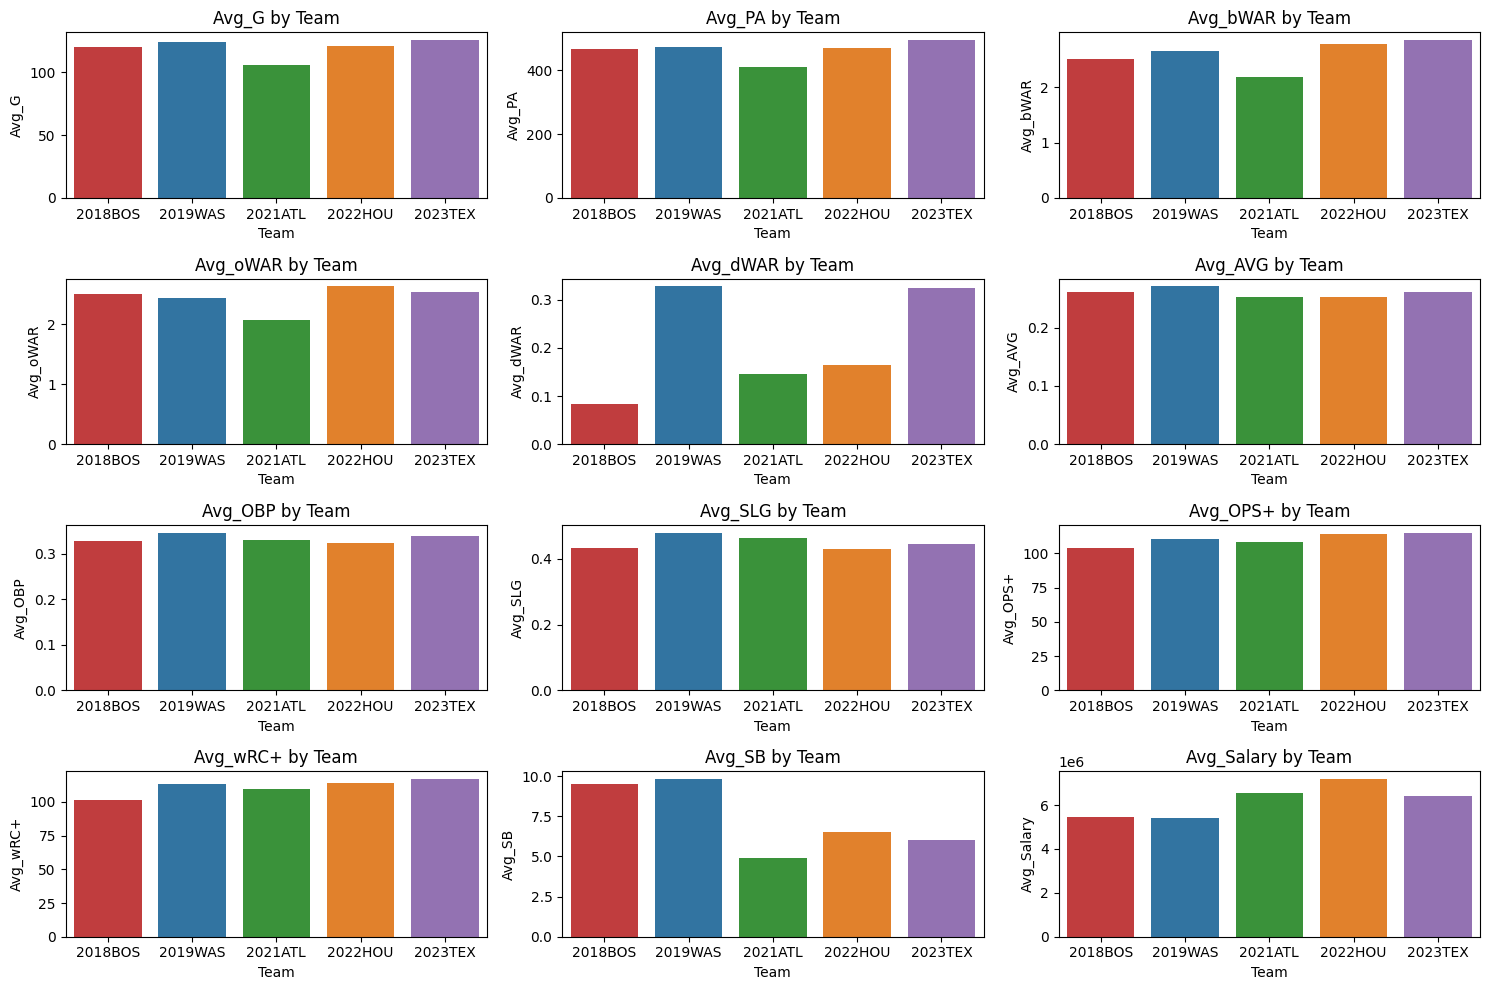

In [ ]:
# Define the custom order of teams
custom_order = ['2018BOS', '2019WAS', '2021ATL', '2022HOU', '2023TEX']

# Assign custom order to the 'Team' column
df['Team'] = pd.Categorical(df['Team'], categories=custom_order, ordered=True)

# Define a color palette for the teams
team_colors = {
    '2018BOS': '#d62728',
    '2019WAS': '#1f77b4',
    '2021ATL': '#2ca02c',
    '2022HOU': '#ff7f0e',
    '2023TEX': '#9467bd'
}

# Define number of rows and columns for the grid (adjust based on number of KPIs)
nrows = 4  # Adjust this based on how many KPIs you have
ncols = 3  # Adjust this based on how many KPIs you have
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, i in enumerate(kpis):
    # Create the barplot, specifying the palette to color bars by 'Team'
    sns.barplot(
        data=df,
        x='Team',
        y=f'Avg_{i}',
        ax=axes[idx],
        palette=team_colors
    )
    axes[idx].set_title(f"Avg_{i} by Team")

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the entire grid of bar graphs
plt.show()


# ANOVA Testing of Pitching KPIs by World Series Team

In [ ]:
# Load Excel data
df2 = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/Baseball.xlsx",sheet_name="Pitchers")

# KPIs to test
p_kpis = ["G", "GS", "IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"]

In [ ]:
run_anova_tests(df=df2, kpis=["G", "GS", "IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"])


Running ANOVA for G:

ANOVA Table:
+----------+-------------------+------+---------------------+--------------------+
|          |      sum_sq       |  df  |          F          |       PR(>F)       |
+----------+-------------------+------+---------------------+--------------------+
| C(Team)  | 297.2766122766128 | 4.0  | 0.18660182501784767 | 0.9442829620502068 |
| Residual | 19515.55672105672 | 49.0 |         nan         |        nan         |
+----------+-------------------+------+---------------------+--------------------+

Tukey HSD Test:
+---+---------+---------+----------+--------+----------+---------+--------+
|   | group1  | group2  | meandiff | p-adj  |  lower   |  upper  | reject |
+---+---------+---------+----------+--------+----------+---------+--------+
| 0 | 2018BOS | 2019WAS | -1.2735  | 0.9999 | -25.7808 | 23.2338 | False  |
| 1 | 2018BOS | 2021ATL |  1.1154  | 0.9999 | -22.6568 | 24.8876 | False  |
| 2 | 2018BOS | 2022HOU |  3.2517  | 0.9945 | -19.9016 | 26.4051 | Fa

In [ ]:
#From the ANOVA p value of 0.017877 for ERA we see that there is a statistically significant difference between:

# 2019 WAS and 2022 HOU with a tukey p value of 0.0355
# 2022 HOU and 2023 TEX with a tukey p value of 0.0214
#however the bonferroni posthoc does not believe that there is a statistical difference for either


# Other than that, there seems to be no statistically significant difference among pitchers of the world series winning teams, but there are some that
# come close such as:

# FIP of 2022 HOU and 2023 TEX at 0.0768 p value in the Tukey with an ANOVA p value of 0.115734

# WHIP of 2018 BOS and 2022 HOU at 0.0742 p value in the Tukey and ANOVA almost classifies as  significant at 0.078995

# World Series Batting KPI Visualizations

In [ ]:
for i in p_kpis:
  avg = df2.groupby('Team')[i].mean()
  df2[f'Avg_{i}'] = df2['Team'].map(avg)

df2.head()

,Team,Name,Age,G,GS,IP,WAR,ERA,ERA+,K/9,...,Avg_G,Avg_GS,Avg_IP,Avg_WAR,Avg_ERA,Avg_ERA+,Avg_K/9,Avg_FIP,Avg_WHIP,Avg_Salary
0,2023TEX,Dane Dunning,28,35,26,172.2,3.0,3.70,116,7.3,...,36.636364,13.363636,100.927273,1.218182,4.099091,109.636364,8.463636,4.168182,1.214182,7.553557e+06
1,2023TEX,Jon Gray,31,29,29,157.1,2.1,4.12,104,8.1,...,36.636364,13.363636,100.927273,1.218182,4.099091,109.636364,8.463636,4.168182,1.214182,7.553557e+06
2,2023TEX,Andrew Heaney,32,34,28,147.1,1.3,4.15,103,9.2,...,36.636364,13.363636,100.927273,1.218182,4.099091,109.636364,8.463636,4.168182,1.214182,7.553557e+06
3,2023TEX,Nathan Eovaldi,33,25,25,144.0,3.1,3.63,118,8.3,...,36.636364,13.363636,100.927273,1.218182,4.099091,109.636364,8.463636,4.168182,1.214182,7.553557e+06
4,2023TEX,Martin Perez,32,35,20,141.2,0.8,4.45,96,5.9,...,36.636364,13.363636,100.927273,1.218182,4.099091,109.636364,8.463636,4.168182,1.214182,7.553557e+06


<ipython-input-31-389964e0d861>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-31-389964e0d861>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-31-389964e0d861>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-31-389964e0d861>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-31-389964e0d861>:26: FutureWarning: 

Passing `pa

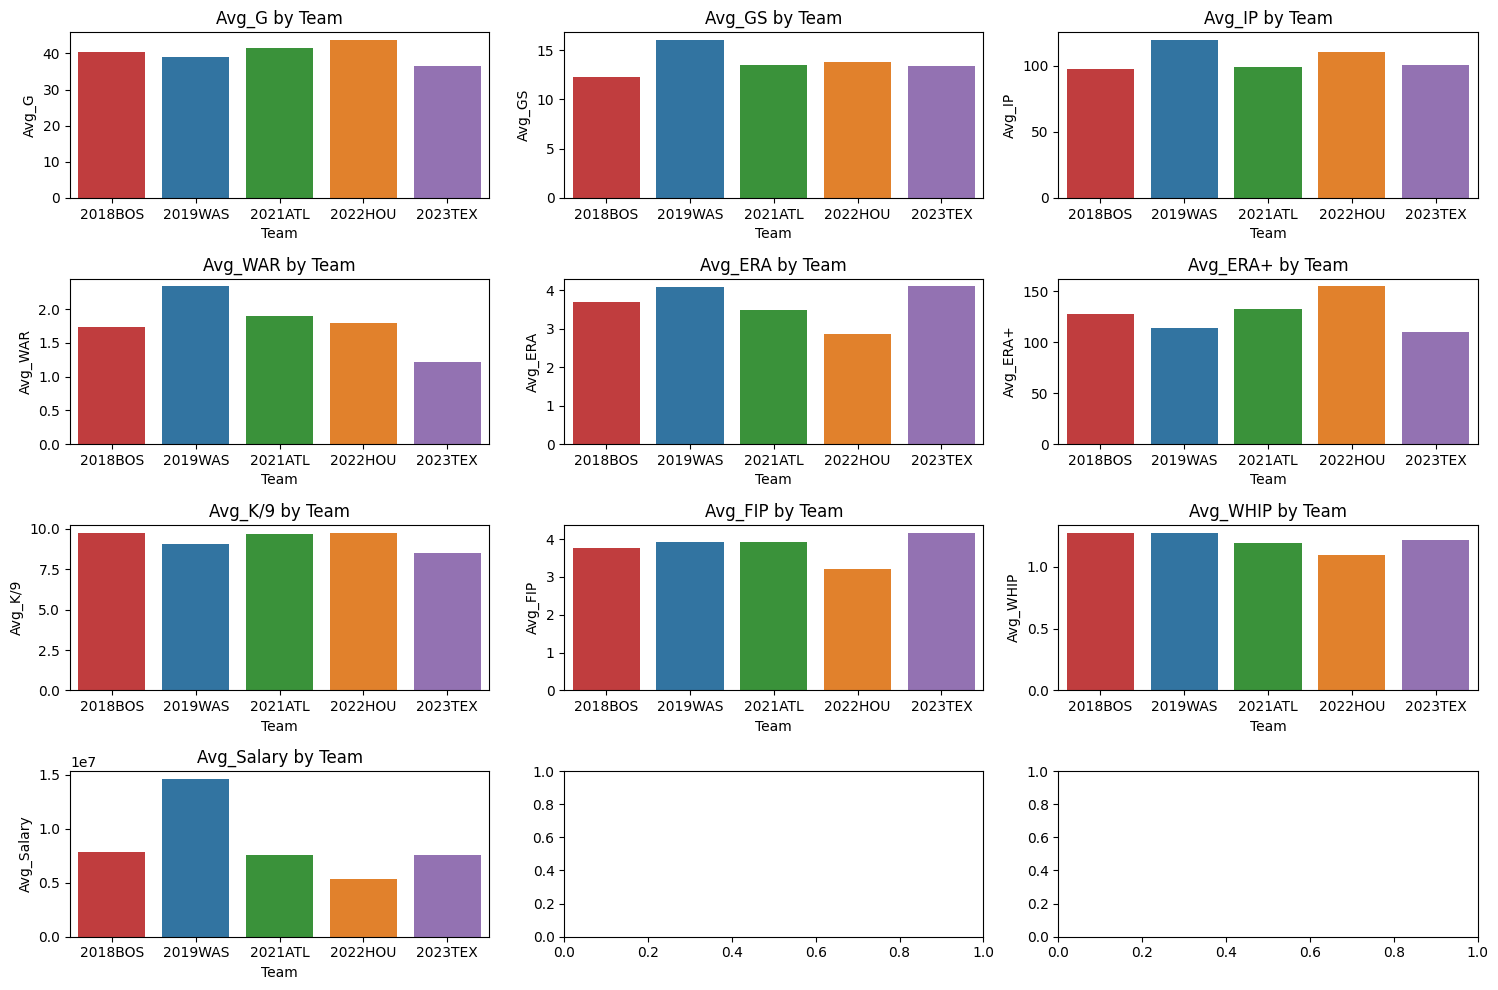

In [ ]:
# Define the custom order of teams
custom_order = ['2018BOS', '2019WAS', '2021ATL', '2022HOU', '2023TEX']

# Assign custom order to the 'Team' column
df2['Team'] = pd.Categorical(df2['Team'], categories=custom_order, ordered=True)

# Define a color palette for the teams
team_colors = {
    '2018BOS': '#d62728',
    '2019WAS': '#1f77b4',
    '2021ATL': '#2ca02c',
    '2022HOU': '#ff7f0e',
    '2023TEX': '#9467bd'
}

# Define number of rows and columns for the grid (adjust based on number of KPIs)
nrows = 4  # Adjust this based on how many KPIs you have
ncols = 3  # Adjust this based on how many KPIs you have
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, i in enumerate(p_kpis):
    # Create the barplot, specifying the palette to color bars by 'Team'
    sns.barplot(
        data=df2,
        x='Team',
        y=f'Avg_{i}',
        ax=axes[idx],
        palette=team_colors
    )
    axes[idx].set_title(f"Avg_{i} by Team")

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the entire grid of bar graphs
plt.show()


# League Comparison Data

In [ ]:
#2023 data
df_2023_hit = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202023.xlsx",sheet_name="2023 League Hitting")
df_2023_pitch = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202023.xlsx",sheet_name="2023 League Pitching")

#2022 data
df_2022_hit = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202022.xlsx",sheet_name="2022 League Hitting")
df_2022_pitch = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202022.xlsx",sheet_name="2022 League Pitching")

#2021 data
df_2021_hit = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202021.xlsx",sheet_name="2021 League Hitting")
df_2021_pitch = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202021.xlsx",sheet_name="2021 League Pitching")

#2019 data
df_2019_hit = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202019.xlsx",sheet_name="2019 League Hitting")
df_2019_pitch = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202019.xlsx",sheet_name="2019 League Pitching")

#2018 data
df_2018_hit = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202018.xlsx",sheet_name="2018 League Hitting")
df_2018_pitch = pd.read_excel("https://github.com/enosnas/Sports-Analytics/raw/refs/heads/main/MLB%20Stats%202018.xlsx",sheet_name="2018 League Pitching")

In [ ]:
df_2018_pitch.head()

,Team,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,FIP,WHIP,H9,HR9,BB9,K/9,SO/W,LOB,WAR,Salary
0,Arizona Diamondbacks,30,29.6,3.98,82,80,0.506,3.72,162,162,...,3.91,1.254,8.1,1.1,3.2,8.9,2.77,1106,12.0,160972085.0
1,Atlanta Braves,35,27.7,4.06,90,72,0.556,3.75,162,162,...,3.98,1.284,7.6,0.9,3.9,8.8,2.24,1128,15.1,164543596.0
2,Baltimore Orioles,30,27.1,5.51,47,115,0.290,5.18,162,162,...,4.98,1.496,9.8,1.5,3.7,7.6,2.04,1155,7.1,151534675.0
3,Boston Red Sox,23,28.9,3.99,108,54,0.667,3.75,162,162,...,3.82,1.246,8.1,1.1,3.2,9.6,3.04,1143,18.5,247979860.0
4,Chicago Cubs,35,30.2,3.96,95,68,0.583,3.65,163,163,...,4.13,1.315,8.0,1.0,3.8,8.1,2.14,1190,14.1,240922525.0


# 2018 Boston Red Sox Batting and Pitching Comparison to League Visualization and Z Scores

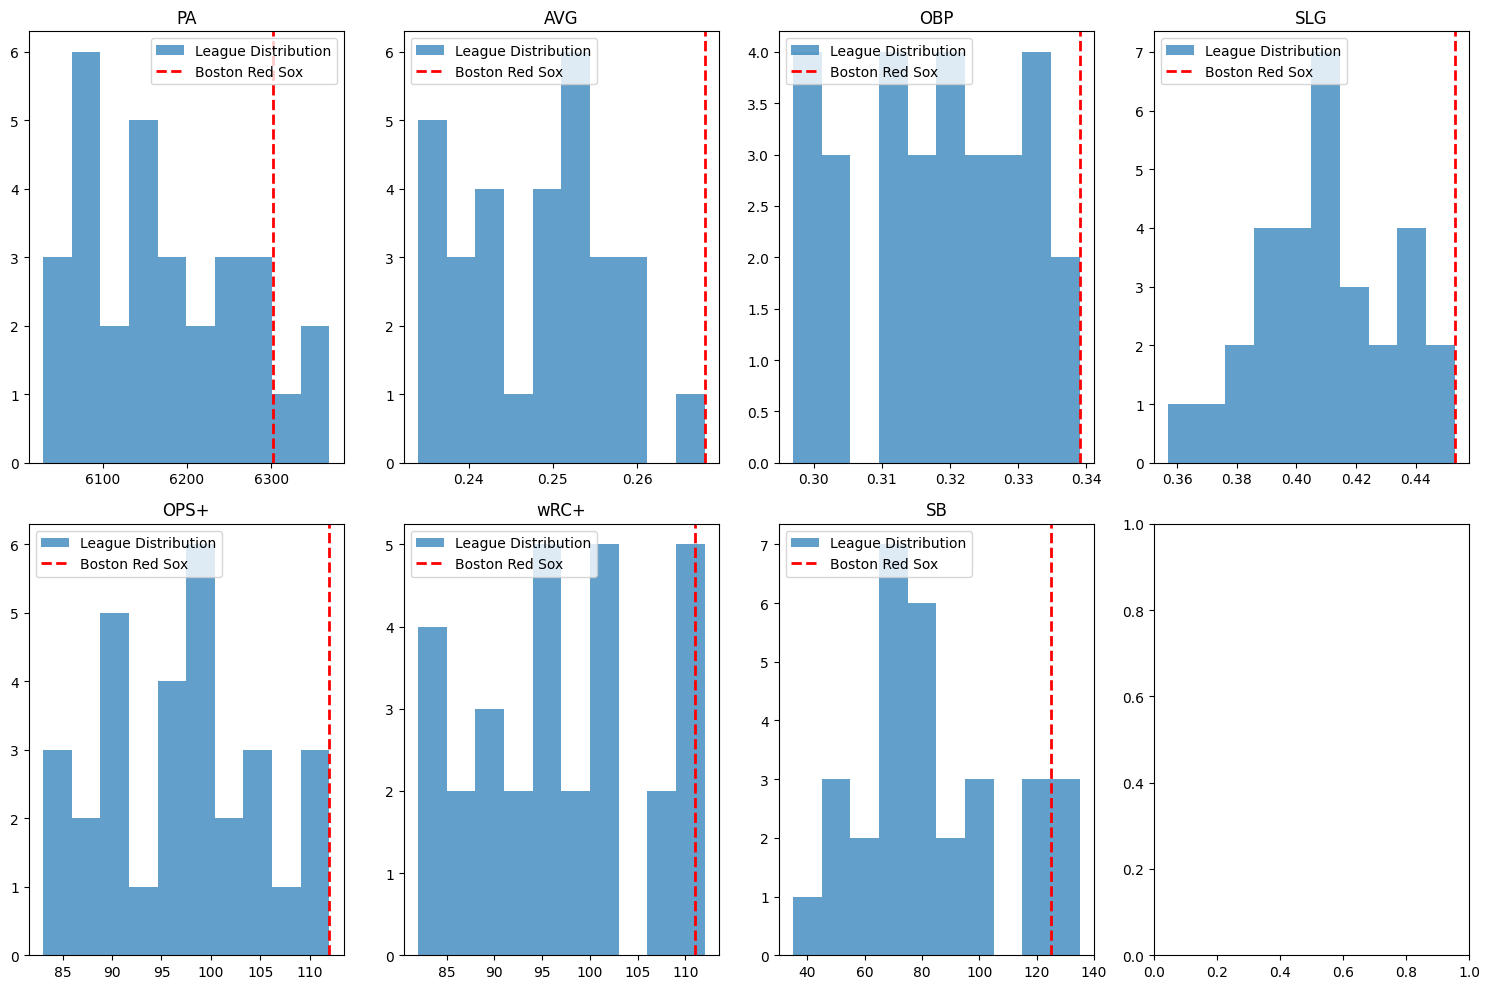

In [ ]:
create_stat_visualization(df_2018_hit[df_2018_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],team="Boston Red Sox")

In [ ]:
calculate_team_z_scores(df_2018_hit[df_2018_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"], team = "Boston Red Sox")

,KPI,Z-Score
0,PA,1.352979
1,AVG,2.246887
2,OBP,1.705455
3,SLG,1.884780
4,OPS+,1.785022
5,wRC+,1.545953
6,SB,1.631101


In [ ]:
# We can see from the z scores that the Red Sox were statistical outliers in terms of team batting average

# For the other KPIs they were all above average in the league, with SLG/OBP/OPS almost also being considered statistical outliers

# PA/wRC+/SB are all well above average but not outliers

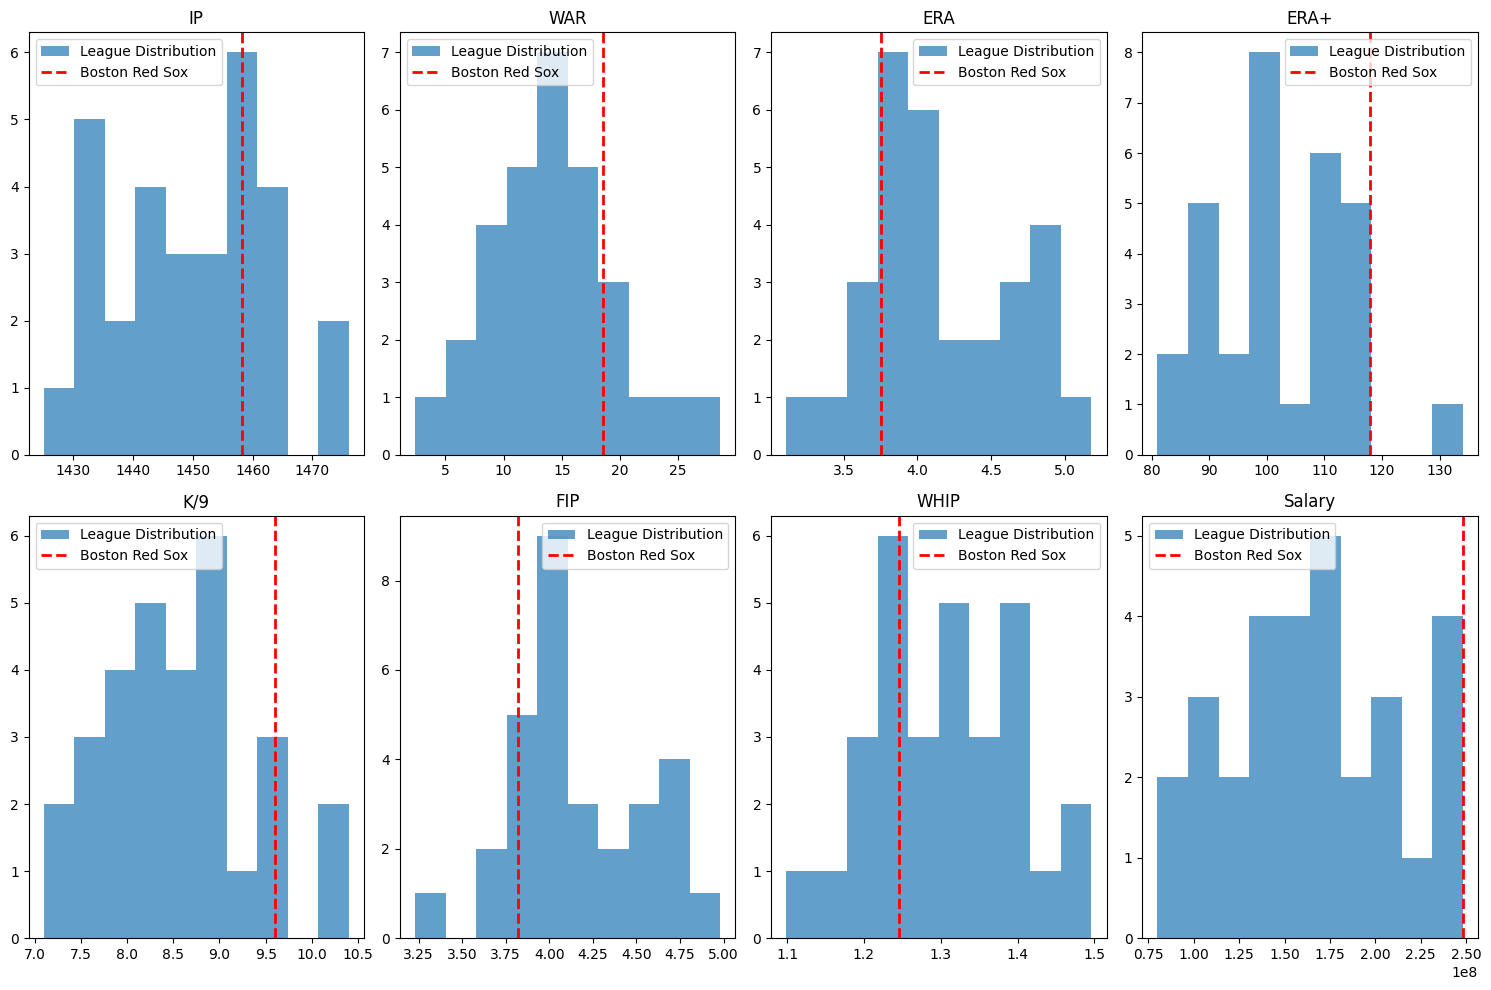

In [ ]:
create_stat_visualization(df_2018_pitch[df_2018_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],team="Boston Red Sox")

In [ ]:
calculate_team_z_scores(df_2018_pitch[df_2018_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"], team = "Boston Red Sox")

,KPI,Z-Score
0,IP,0.655443
1,WAR,0.760513
2,ERA,-0.778620
3,ERA+,1.312180
4,K/9,1.356336
5,FIP,-0.823192
6,WHIP,-0.637019
7,Salary,1.788402


In [ ]:
# We can see from the z scores that the Red Sox were not outliers in terms of pitching KPIs

# FIP/WHIP/ERA being below average by almost 1 standard deviation
# IP/WAR being slightly above average
# K9/Salary/ERA+ were well above average

# 2019 Washington Nationals Batting and Pitching Comparison to League Visualization and Z Scores

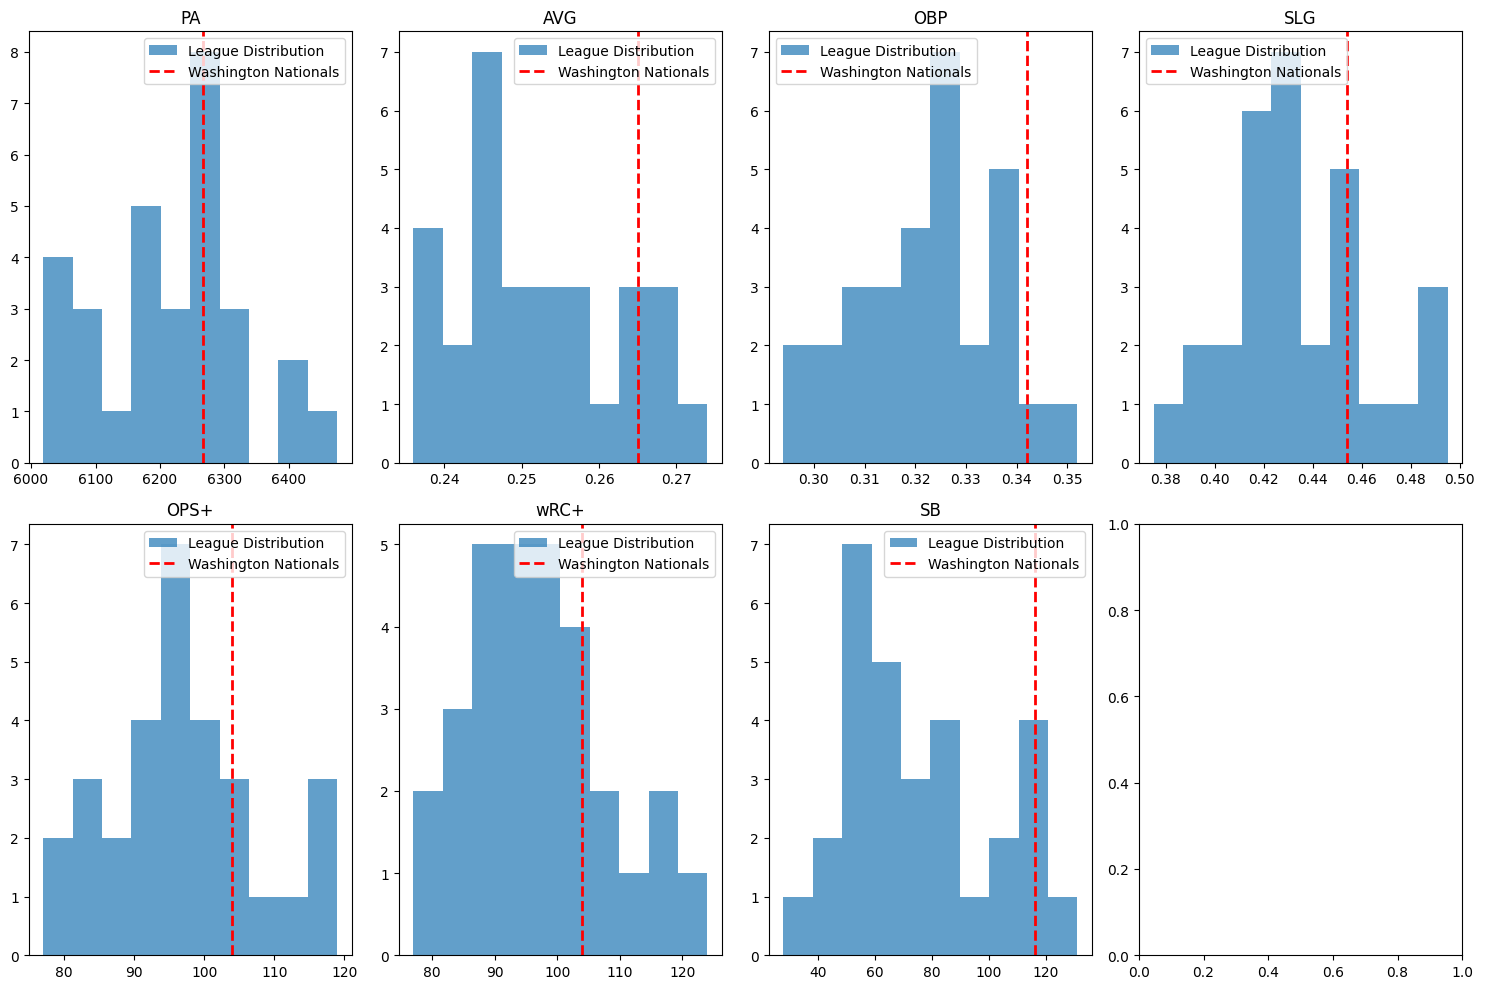

In [ ]:
create_stat_visualization(df_2019_hit[df_2019_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],team="Washington Nationals")

In [ ]:
calculate_team_z_scores(df_2019_hit[df_2019_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"], team = "Washington Nationals")

,KPI,Z-Score
0,PA,0.436610
1,AVG,1.183452
2,OBP,1.412690
3,SLG,0.651233
4,OPS+,0.655312
5,wRC+,0.655961
6,SB,1.538383


In [ ]:
# Once again batting KPIs are all above average

# PA/SLG/OPS+/wRC+ all slightly above
# AVG/OBP/SB well above
# No considerable outliers

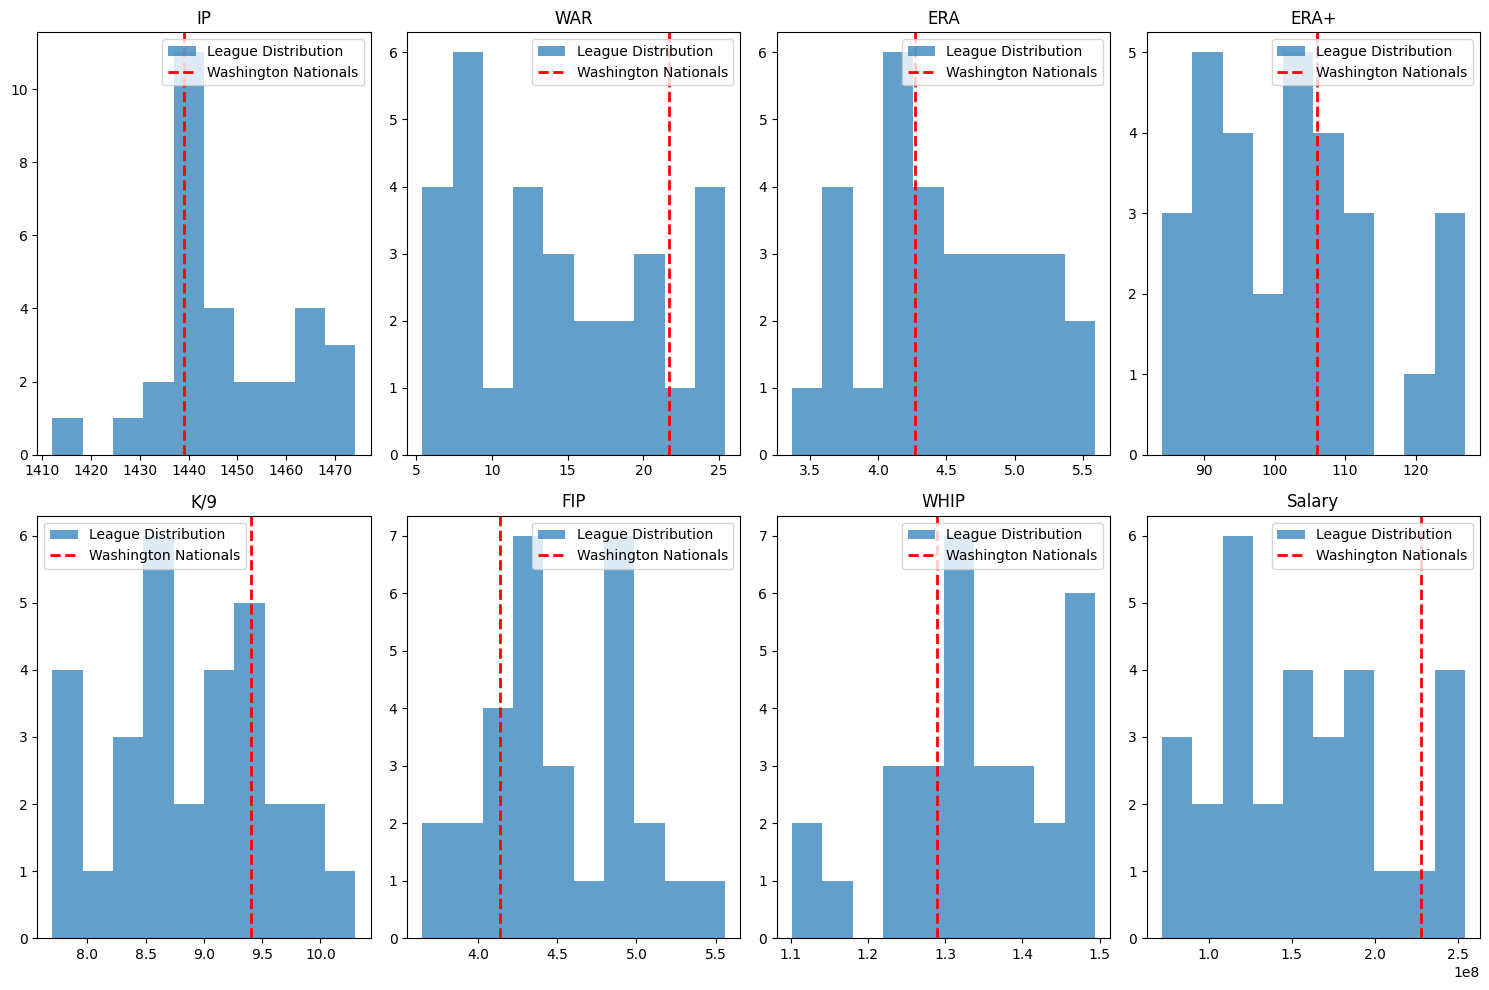

In [ ]:
create_stat_visualization(df_2019_pitch[df_2019_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],team="Washington Nationals")

In [ ]:
calculate_team_z_scores(df_2019_pitch[df_2019_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"], team = "Washington Nationals")

,KPI,Z-Score
0,IP,-0.567466
1,WAR,1.177453
2,ERA,-0.389895
3,ERA+,0.334666
4,K/9,0.761028
5,FIP,-0.814728
6,WHIP,-0.441751
7,Salary,1.316161


In [ ]:
# IP/FIP/WHIP/ERA all below average
# ERA+/K9 slightly above average
# WAR/Salary well above average

# 2021 Atlanta Braves Batting and Pitching Comparison to League Visualization and Z Scores

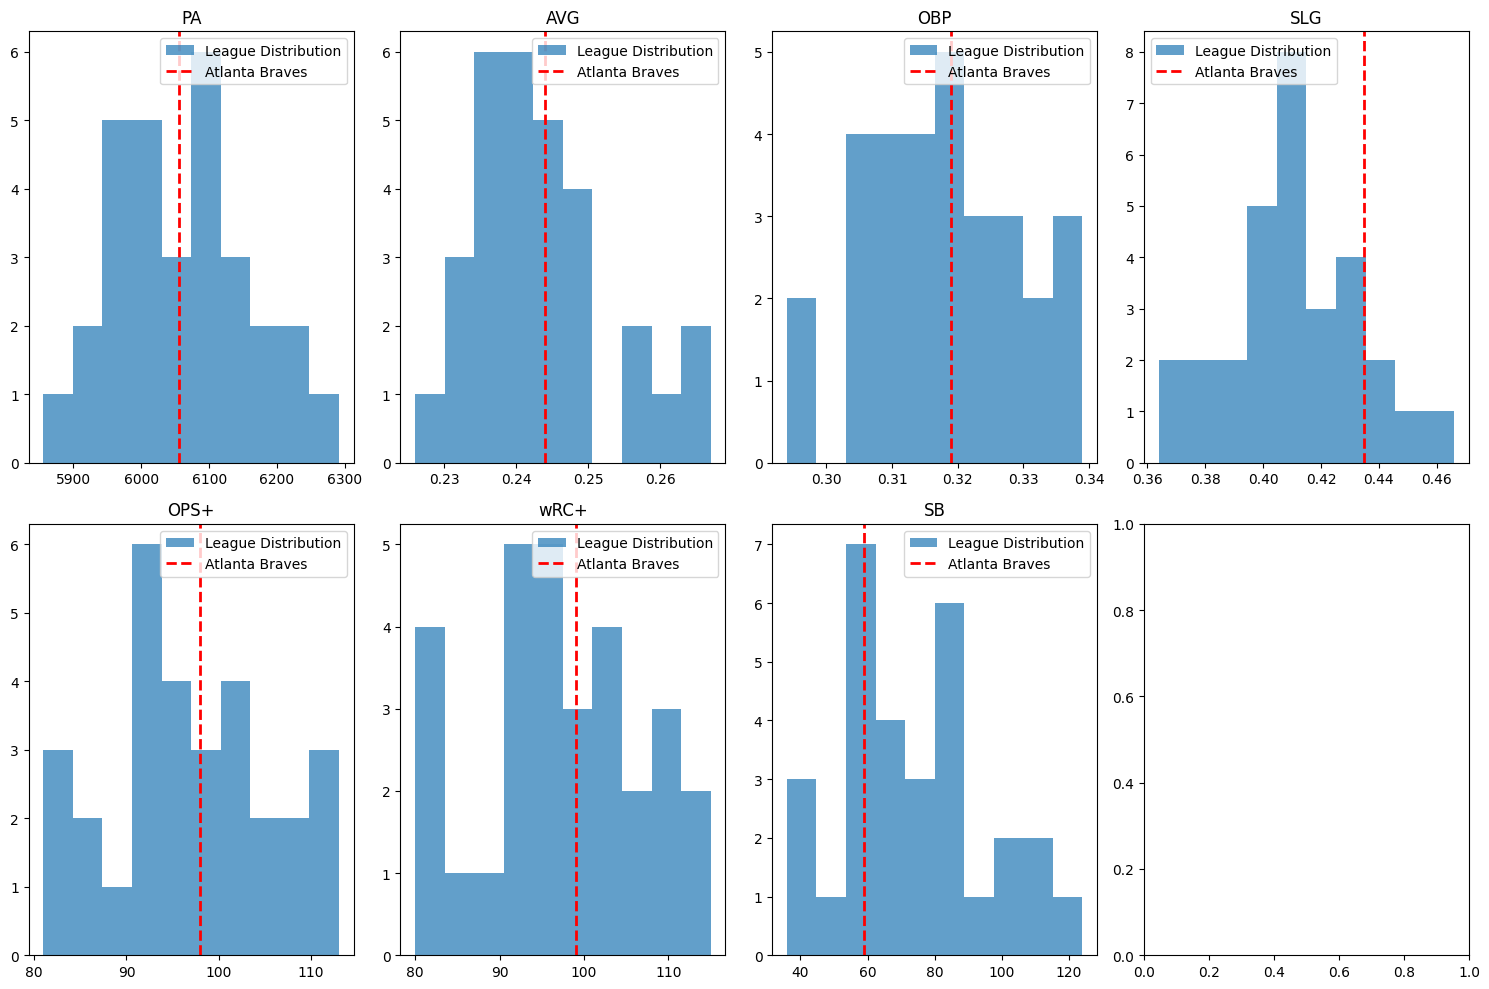

In [ ]:
create_stat_visualization(df_2021_hit[df_2021_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],team="Atlanta Braves")

In [ ]:
calculate_team_z_scores(df_2021_hit[df_2021_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"], team = "Atlanta Braves")

,KPI,Z-Score
0,PA,-0.046427
1,AVG,0.023606
2,OBP,0.180746
3,SLG,1.036992
4,OPS+,0.113833
5,wRC+,0.254094
6,SB,-0.654158


In [ ]:
# most interestingly, the Braves were pretty average in terms of batting when they won
# AVG/OBP/OPS+/wRC+/PA were all pretty close to average
# SB were slightly below average

# SLG was their only stat well above average, but not even an outlier

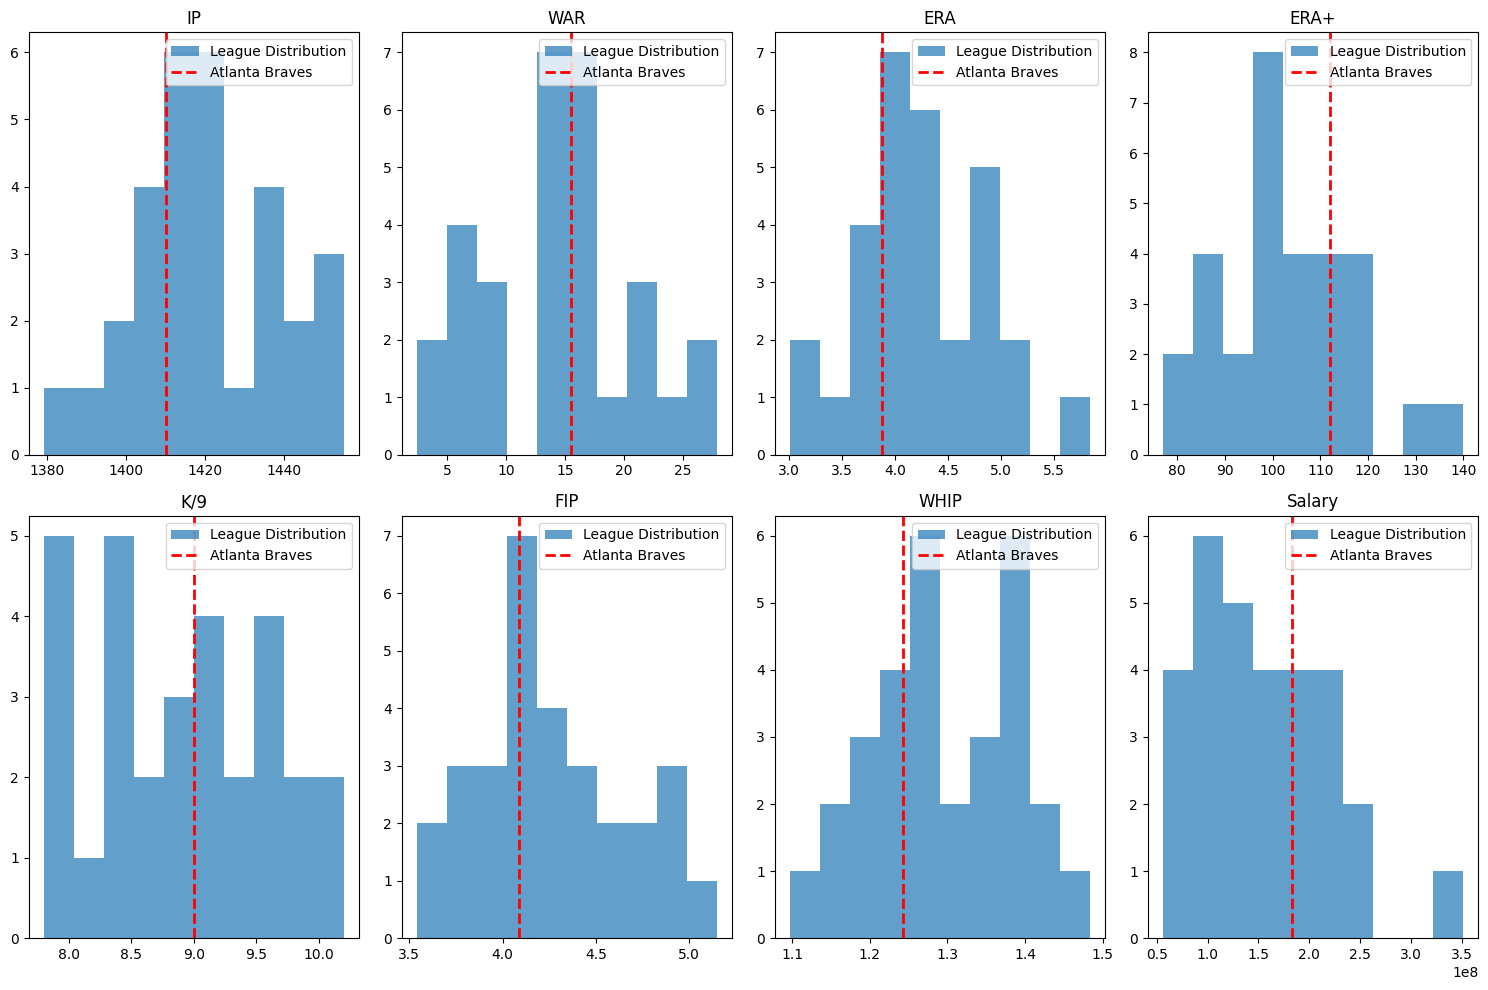

In [ ]:
create_stat_visualization(df_2021_pitch[df_2021_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],team="Atlanta Braves")

In [ ]:
calculate_team_z_scores(df_2021_pitch[df_2021_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"], team = "Atlanta Braves")

,KPI,Z-Score
0,IP,-0.541461
1,WAR,0.176614
2,ERA,-0.627864
3,ERA+,0.664063
4,K/9,0.136851
5,FIP,-0.426569
6,WHIP,-0.577684
7,Salary,0.395932


In [ ]:
# Once again nothing very highlight worthy

# IP/ERA/FIP/WHIP around average/barely below

# WAR/ERA+/K9/Salary around average/barely above

# 2022 Houston Astros Batting and Pitching Comparison to League Visualization and Z Scores

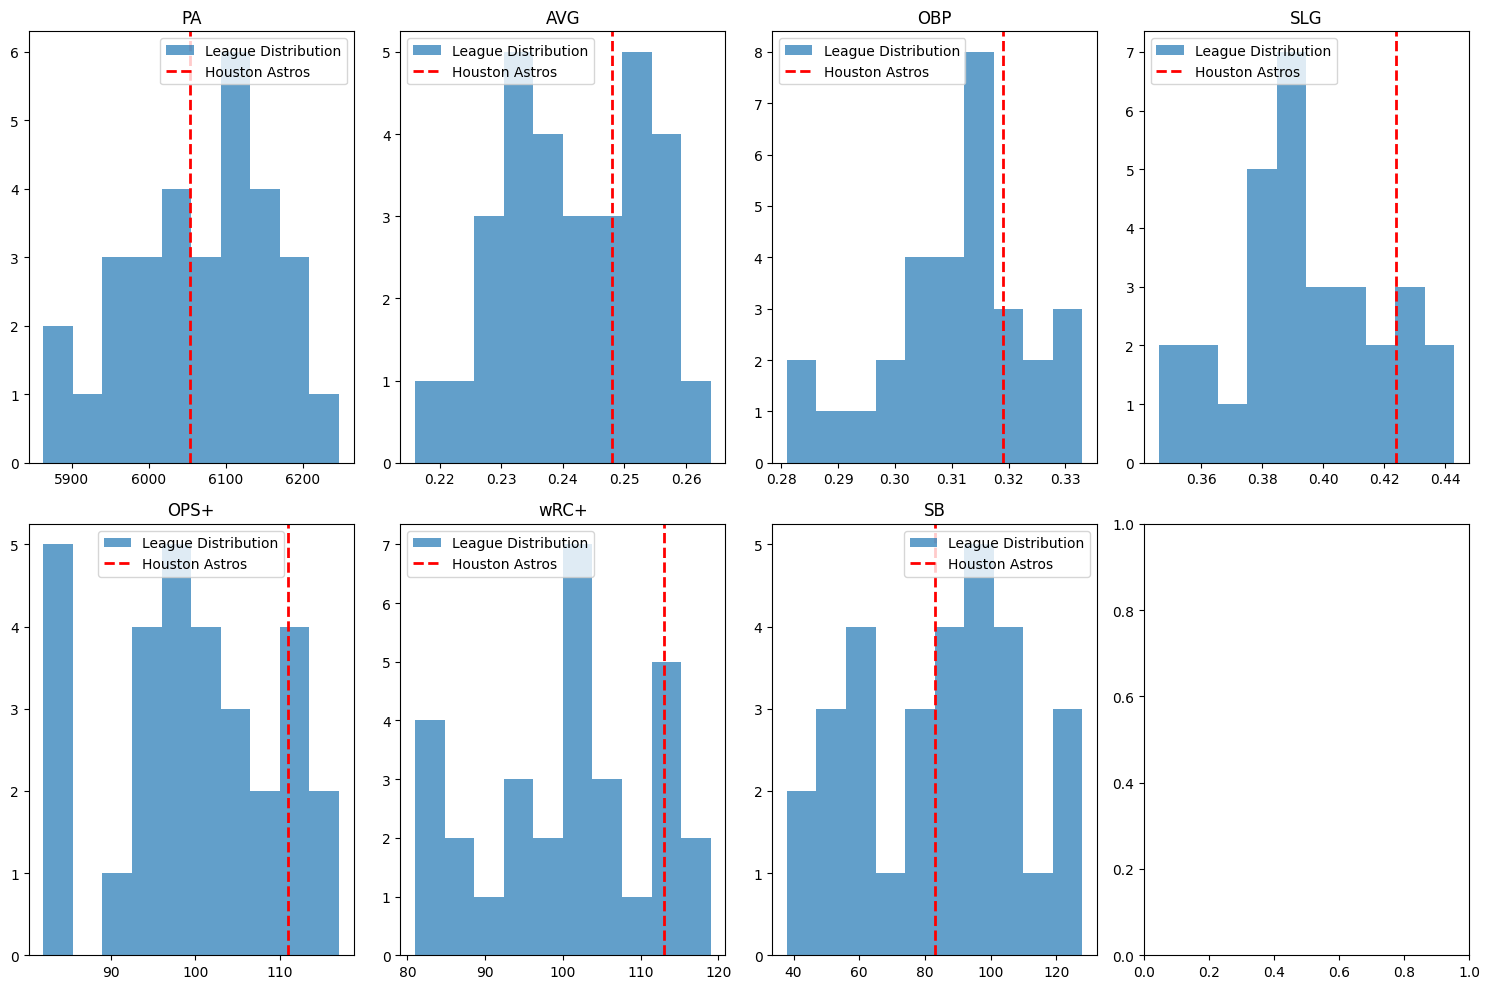

In [ ]:
create_stat_visualization(df_2022_hit[df_2022_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],team="Houston Astros")

In [ ]:
calculate_team_z_scores(df_2022_hit[df_2022_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"], team = "Houston Astros")

,KPI,Z-Score
0,PA,-0.150800
1,AVG,0.449327
2,OBP,0.605922
3,SLG,1.159487
4,OPS+,1.134465
5,wRC+,1.166672
6,SB,0.005421


In [ ]:
# PA just slightly below average
# SB pretty much average

# AVG/OBP slightly above average
#SLG/OPS+/wRC+ above average

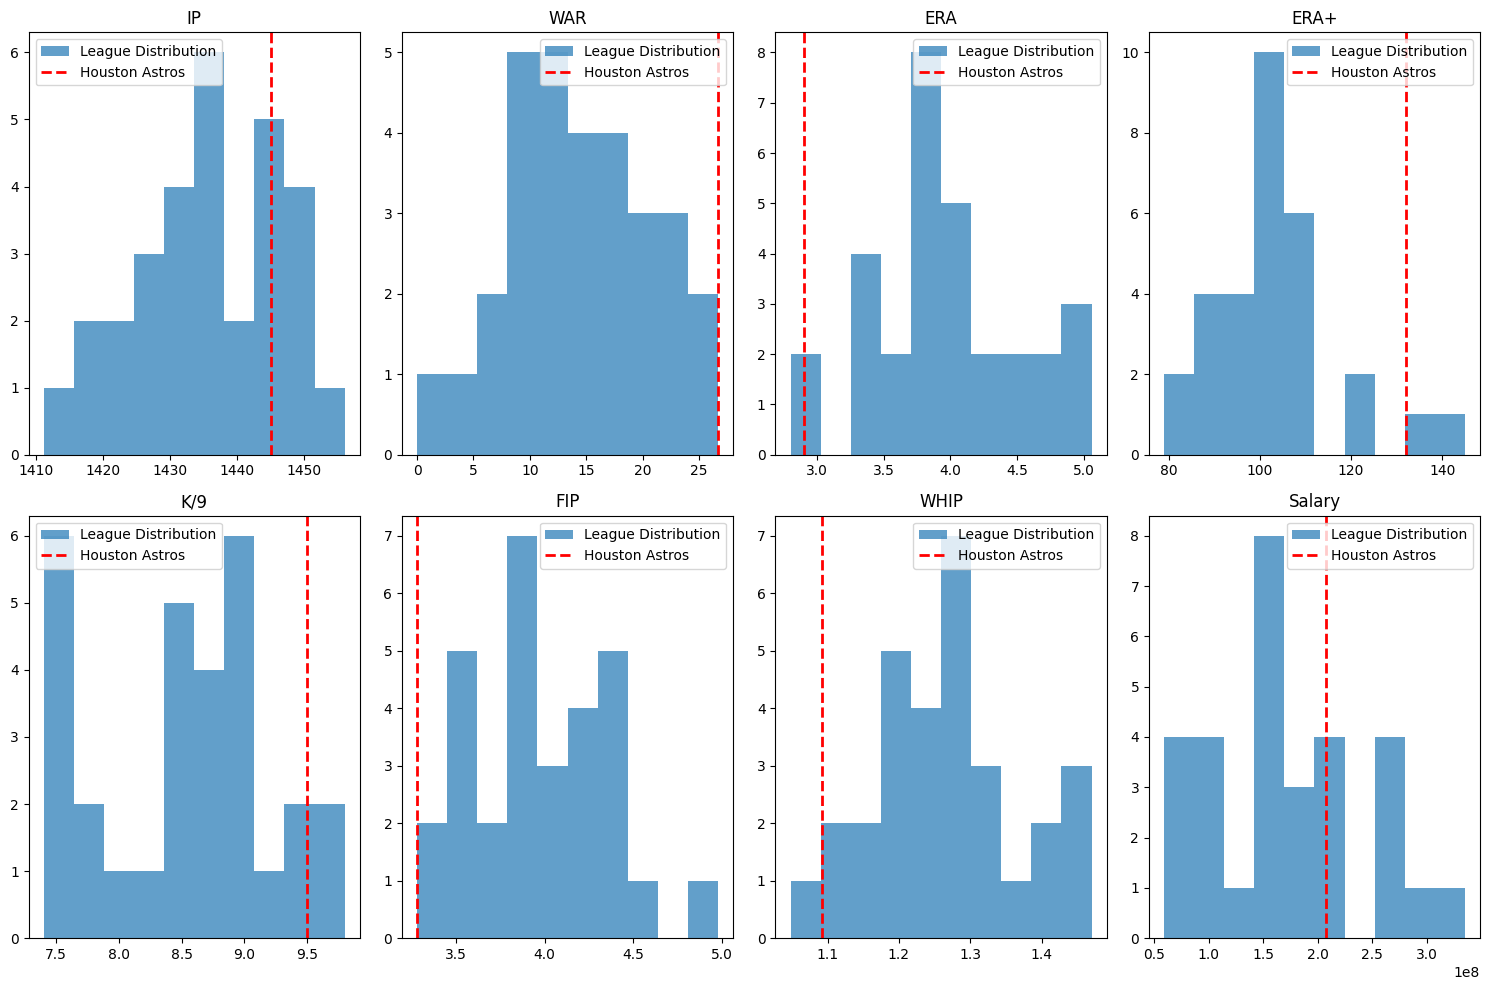

In [ ]:
create_stat_visualization(df_2022_pitch[df_2022_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],team="Houston Astros")

In [ ]:
calculate_team_z_scores(df_2022_pitch[df_2022_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"], team = "Houston Astros")

,KPI,Z-Score
0,IP,0.848764
1,WAR,1.936712
2,ERA,-1.904368
3,ERA+,2.164751
4,K/9,1.390961
5,FIP,-1.755094
6,WHIP,-1.671130
7,Salary,0.496225


In [ ]:
# ERA well below average, practically an outlier and ERA+/WAR are outliers as they are well above average
# FIP and WHIP almost outliers as well

# IP/Salary slightly above average
# K/9 well above average

# 2023 Texas Rangers Batting and Pitching Comparison to League Visualization and Z Scores

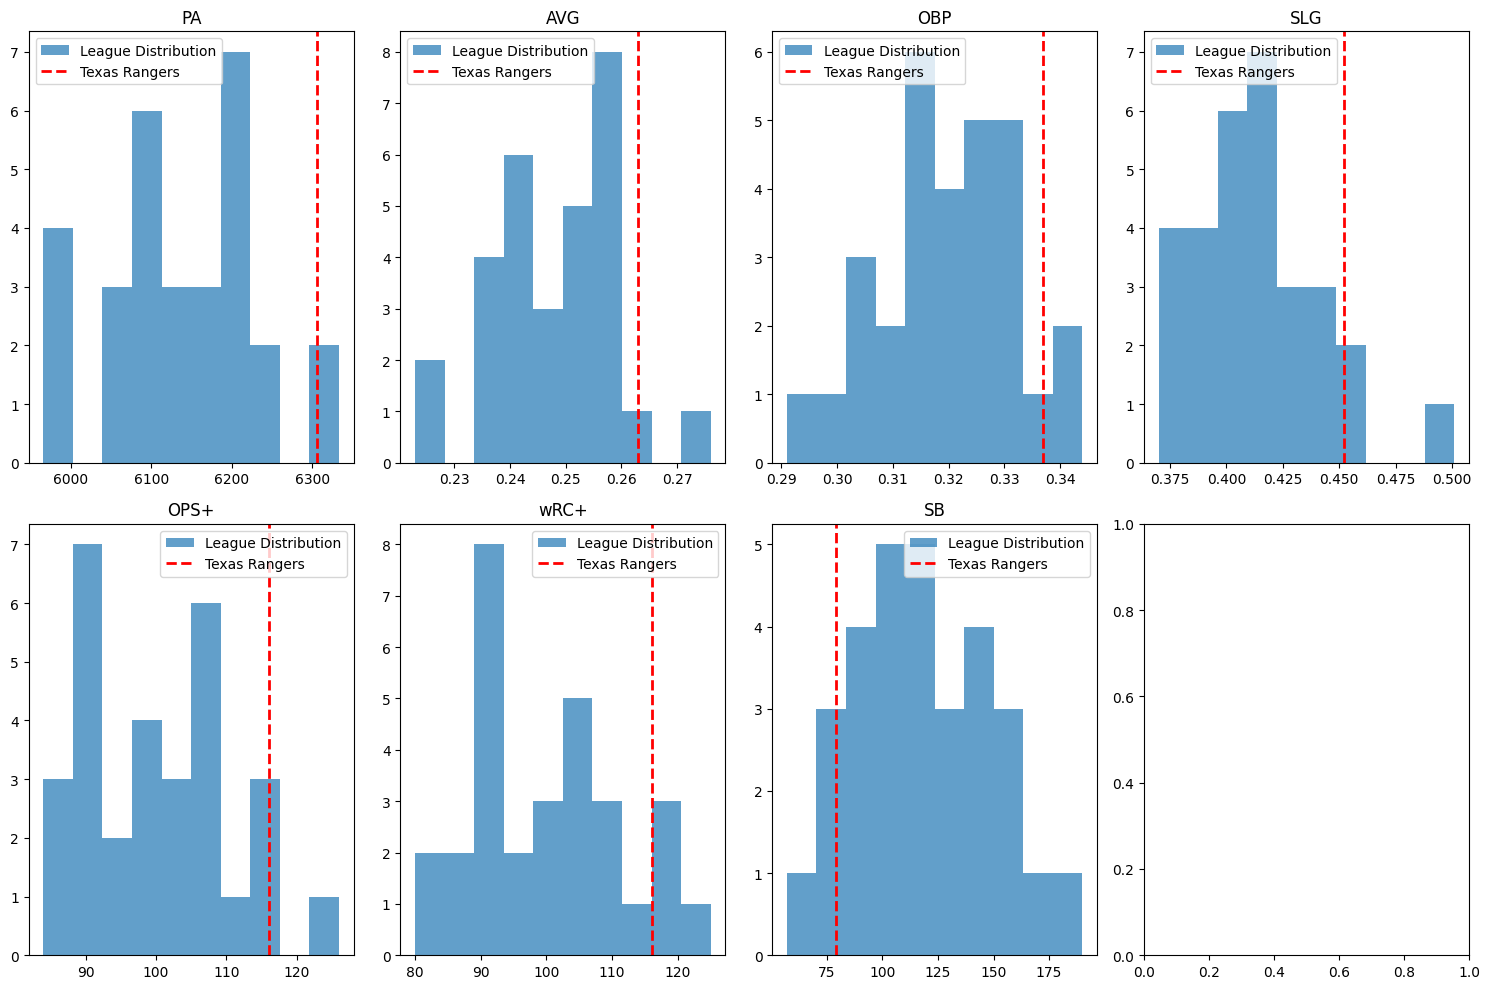

In [ ]:
create_stat_visualization(df_2023_hit[df_2023_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],team="Texas Rangers")

In [ ]:
calculate_team_z_scores(df_2023_hit[df_2023_hit["Team"] != "League Average"], stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"], team = "Texas Rangers")

,KPI,Z-Score
0,PA,1.736823
1,AVG,1.308095
2,OBP,1.389998
3,SLG,1.389161
4,OPS+,1.563238
5,wRC+,1.458693
6,SB,-1.181056


In [ ]:
# SB well below average
# All others are well above, with PA coming close to being an outlier

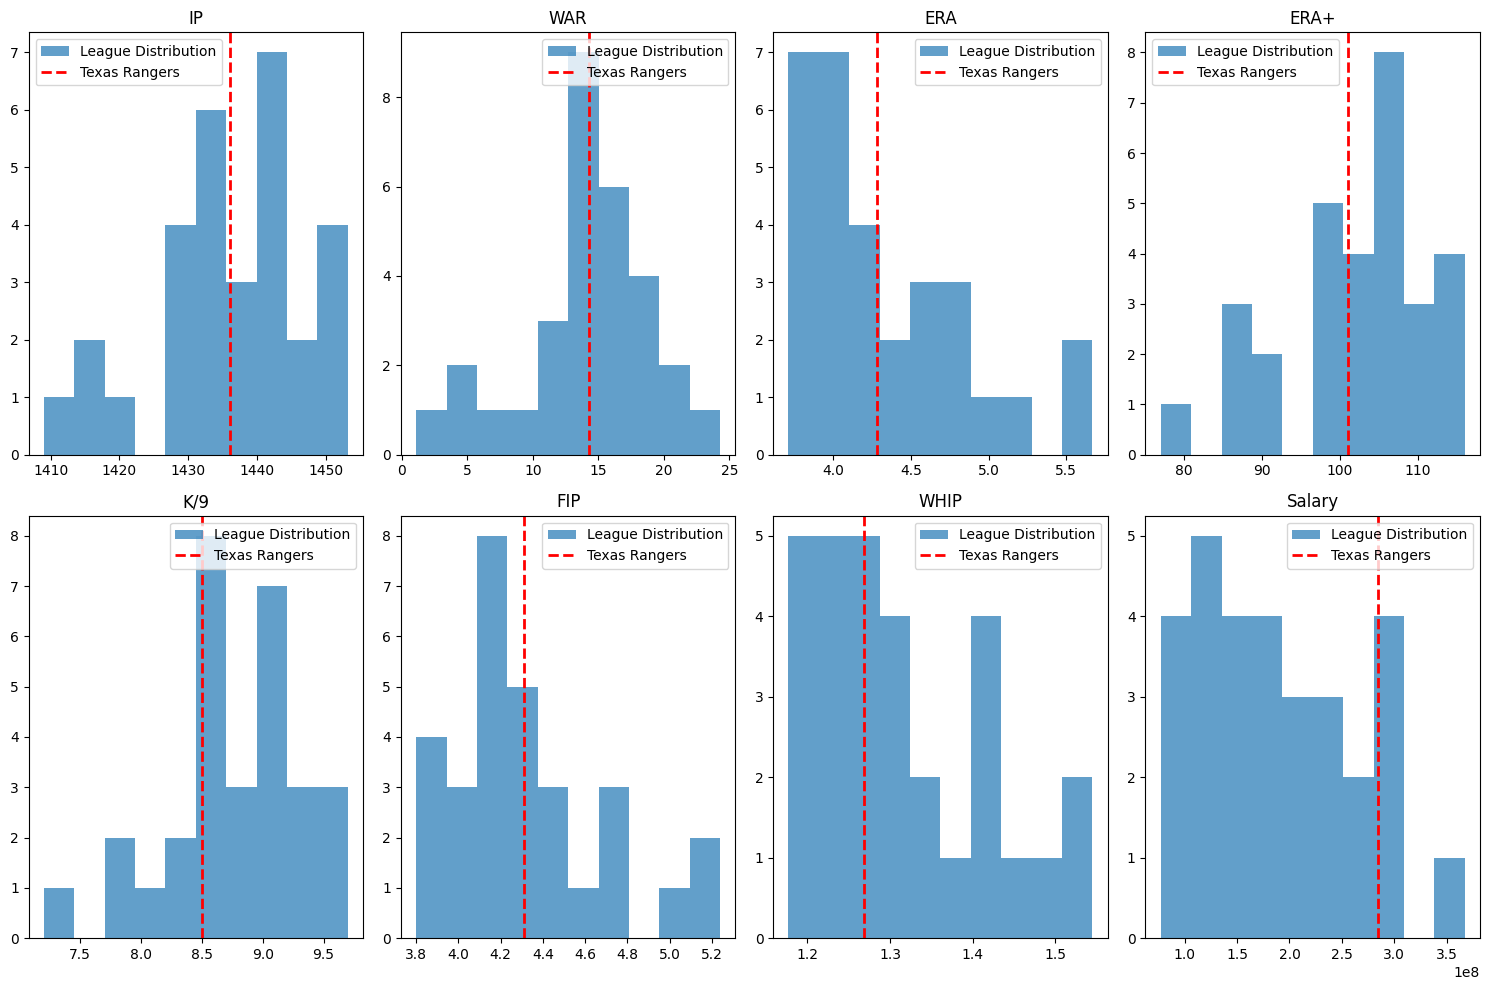

In [ ]:
create_stat_visualization(df_2023_pitch[df_2023_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],team="Texas Rangers")

In [ ]:
calculate_team_z_scores(df_2023_pitch[df_2023_pitch["Team"] != "League Average"], stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"], team = "Texas Rangers")

,KPI,Z-Score
0,IP,0.006642
1,WAR,-0.006654
2,ERA,-0.093324
3,ERA+,-0.096946
4,K/9,-0.422187
5,FIP,-0.064273
6,WHIP,-0.466267
7,Salary,1.337383


In [ ]:
# IP/WAR/ERA/ERA+/FIP all pretty much average

# K9/WHIP slightly below average
# Salary well above average

# Compilation of Z Scores

In [ ]:
# Create empty list to hold DataFrames
z_scores_list = []

# Texas Rangers Z-scores for 2023
z_scores_rangers_2023 = calculate_team_z_scores(df_2023_hit[df_2023_hit["Team"] != "League Average"],
                                                  stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],
                                                  team="Texas Rangers")
z_scores_pitchers_rangers_2023 = calculate_team_z_scores(df_2023_pitch[df_2023_pitch["Team"] != "League Average"],
                                                            stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],
                                                            team="Texas Rangers")

# Append to list
z_scores_list.append(z_scores_rangers_2023)
z_scores_list.append(z_scores_pitchers_rangers_2023)

# Houston Astros Z-scores for 2022
z_scores_astros_2022 = calculate_team_z_scores(df_2022_hit[df_2022_hit["Team"] != "League Average"],
                                                stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],
                                                team="Houston Astros")
z_scores_pitchers_astros_2022 = calculate_team_z_scores(df_2022_pitch[df_2022_pitch["Team"] != "League Average"],
                                                          stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],
                                                          team="Houston Astros")
# Append to list
z_scores_list.append(z_scores_astros_2022)
z_scores_list.append(z_scores_pitchers_astros_2022)

# Atlanta Braves Z-scores for 2021
z_scores_braves_2021 = calculate_team_z_scores(df_2021_hit[df_2021_hit["Team"] != "League Average"],
                                                stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],
                                                team="Atlanta Braves")
z_scores_pitchers_braves_2021 = calculate_team_z_scores(df_2021_pitch[df_2021_pitch["Team"] != "League Average"],
                                                          stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],
                                                          team="Atlanta Braves")
# Append to list
z_scores_list.append(z_scores_braves_2021)
z_scores_list.append(z_scores_pitchers_braves_2021)

# Washington Nationals Z-scores for 2019
z_scores_nationals_2019 = calculate_team_z_scores(df_2019_hit[df_2019_hit["Team"] != "League Average"],
                                                  stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],
                                                  team = "Washington Nationals")
z_scores_pitchers_nationals_2019 = calculate_team_z_scores(df_2019_pitch[df_2019_pitch["Team"] != "League Average"],
                                                           stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],
                                                           team = "Washington Nationals")
# Append to list
z_scores_list.append(z_scores_nationals_2019)
z_scores_list.append(z_scores_pitchers_nationals_2019)

# Boston Red Sox Z-scores for 2019
z_scores_redsox_2018 = calculate_team_z_scores(df_2018_hit[df_2018_hit["Team"] != "League Average"],
                                               stats=["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB"],
                                               team = "Boston Red Sox")
z_scores_pitchers_redsox_2018 = calculate_team_z_scores(df_2018_pitch[df_2018_pitch["Team"] != "League Average"],
                                                        stats=["IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"],
                                                        team = "Boston Red Sox")
# Append to list
z_scores_list.append(z_scores_redsox_2018)
z_scores_list.append(z_scores_pitchers_redsox_2018)

# Combine all DataFrames into a single DataFrame
combined_z_scores = pd.concat(z_scores_list, ignore_index=True)

# Reshape the DataFrame using pivot to have one column for team name and individual columns for KPIs
wide_z_scores = combined_z_scores.pivot(index='Team', columns='KPI', values='Z-Score')

# Reset index to turn the index into a column
wide_z_scores.reset_index(inplace=True)

# Display the wide format DataFrame
wide_z_scores


KPI,Team,AVG,ERA,ERA+,FIP,IP,K/9,OBP,OPS+,PA,SB,SLG,Salary,WAR,WHIP,wRC+
0,Atlanta Braves,0.023606,-0.627864,0.664063,-0.426569,-0.541461,0.136851,0.180746,0.113833,-0.046427,-0.654158,1.036992,0.395932,0.176614,-0.577684,0.254094
1,Boston Red Sox,2.246887,-0.778620,1.312180,-0.823192,0.655443,1.356336,1.705455,1.785022,1.352979,1.631101,1.884780,1.788402,0.760513,-0.637019,1.545953
2,Houston Astros,0.449327,-1.904368,2.164751,-1.755094,0.848764,1.390961,0.605922,1.134465,-0.150800,0.005421,1.159487,0.496225,1.936712,-1.671130,1.166672
3,Texas Rangers,1.308095,-0.093324,-0.096946,-0.064273,0.006642,-0.422187,1.389998,1.563238,1.736823,-1.181056,1.389161,1.337383,-0.006654,-0.466267,1.458693
4,Washington Nationals,1.183452,-0.389895,0.334666,-0.814728,-0.567466,0.761028,1.412690,0.655312,0.436610,1.538383,0.651233,1.316161,1.177453,-0.441751,0.655961


# Z Score Heatmap

<ipython-input-118-f171daf03c6b>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_map = wide_z_scores.iloc[:, 1:].applymap(get_color)  # Exclude the 'Team' column


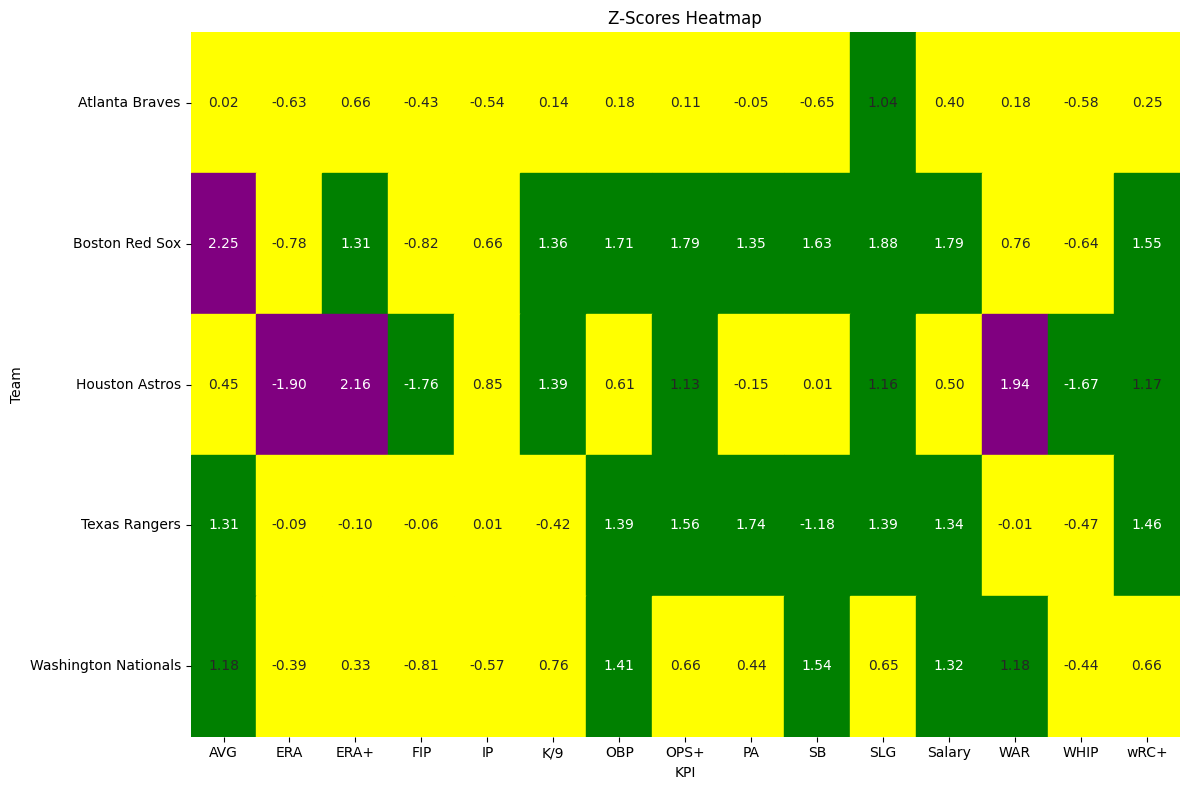

In [ ]:
# Create a function to determine the color based on the Z-Score
def get_color(value):
    if -1 <= value <= 1:
        return 'yellow'    # Highlight yellow for values between -1 and 1
    elif -1.9 <= value < -1 or 1 < value <= 1.9:
        return 'green'     # Highlight green for values between -1 and -1.9 and 1 and 1.9
    else:
        return 'purple'    # Highlight purple for values < -1.9 or > 1.9

# Apply the function to create a DataFrame of colors
color_map = wide_z_scores.iloc[:, 1:].applymap(get_color)  # Exclude the 'Team' column

# Plotting the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    wide_z_scores.iloc[:, 1:],   # Exclude the 'Team' column
    annot=True,                   # Annotate the cells with the Z-scores
    fmt=".2f",                   # Format for the numbers
    cmap='coolwarm',             # Use a color map
    cbar=False,                  # Disable the color bar
    linewidths=1,               # Line width for cell borders
    linecolor='black',           # Line color for borders
    mask=color_map.isnull()      # Mask to avoid color overlap
)

# Overlay the color map
for (i, j), val in np.ndenumerate(wide_z_scores.iloc[:, 1:]):
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=color_map.iloc[i, j]))

# Set the y-ticks to the actual team names and center them
num_teams = len(wide_z_scores)
plt.yticks(ticks=np.arange(num_teams) + 0.5, labels=wide_z_scores['Team'], rotation=0)  # +0.5 centers the ticks

plt.title('Z-Scores Heatmap')
plt.xticks(rotation=0)
plt.ylabel('Team')
plt.xlabel('KPI')
plt.tight_layout()
plt.show()


For this mapping:

*   Anything with a z score between -1 and 1 is yellow to highlight that it isnt too different from the mean
*   Anything between -1 and -1.9 or 1 and 1.9 is green to show that is is quite above average and close to being an outlier
*   Anything over 1.9/-1.9 is purple to show it is a significant outlier in performance





# Z Score Bar Graph Comparison

<ipython-input-105-863fa4fbdac7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-105-863fa4fbdac7>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-105-863fa4fbdac7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-105-863fa4fbdac7>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
<ipython-input-105-863fa4fbdac7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. 

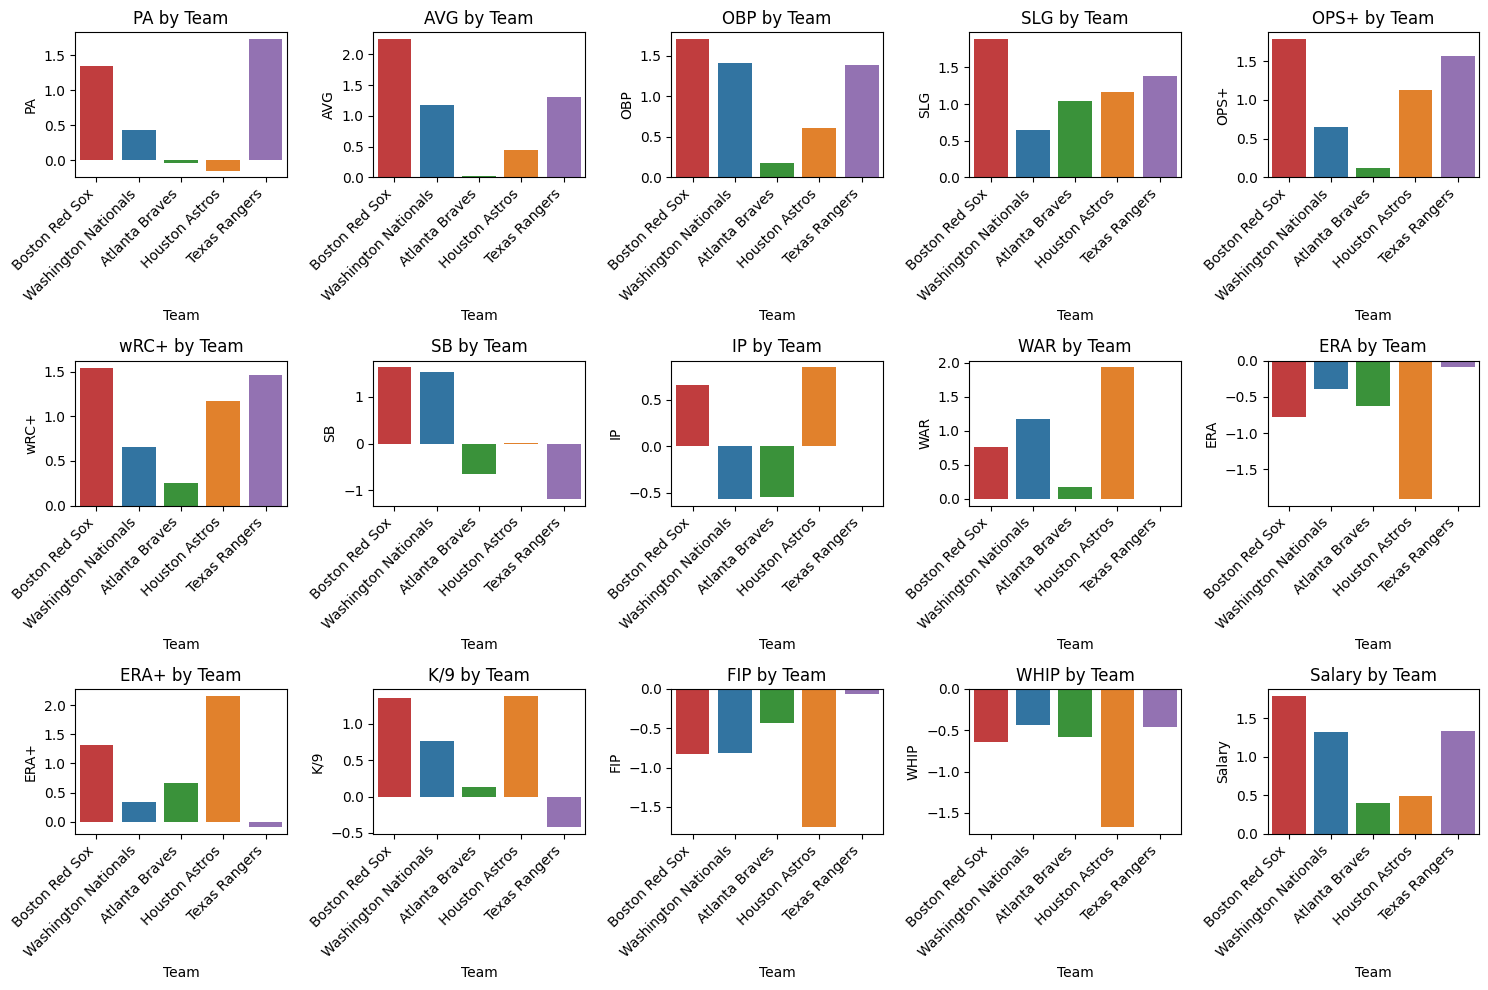

In [ ]:
# Define KPIs
z_kpi = ["PA", "AVG", "OBP", "SLG", "OPS+", "wRC+", "SB", "IP", "WAR", "ERA", "ERA+", "K/9", "FIP", "WHIP", "Salary"]

# Define the custom order of teams
custom_order = ['Boston Red Sox', 'Washington Nationals', 'Atlanta Braves', 'Houston Astros', 'Texas Rangers']

# Assign custom order to the 'Team' column
wide_z_scores['Team'] = pd.Categorical(wide_z_scores['Team'], categories=custom_order, ordered=True)

# Define a color palette for the teams
team_colors = {
    'Boston Red Sox': '#d62728',
    'Washington Nationals': '#1f77b4',
    'Atlanta Braves': '#2ca02c',
    'Houston Astros': '#ff7f0e',
    'Texas Rangers': '#9467bd'
}

# Define number of rows and columns for the grid (adjust based on number of KPIs)
nrows = 3  # Adjust this based on how many KPIs you have
ncols = 5  # Adjust this based on how many KPIs you have
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, kpi in enumerate(z_kpi):
    # Create the barplot, specifying the palette to color bars by 'Team'
    sns.barplot(
        data=wide_z_scores,
        x='Team',
        y=kpi,
        ax=axes[idx],
        palette=team_colors
    )
    axes[idx].set_title(f"{kpi} by Team")

    # Rotate the x-axis labels
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the entire grid of bar graphs
plt.show()
